In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import sys

In [2]:
def getFirstEqGroupPackForMili(table):
    packOfSet = dict()
    
    existsCombinations = set()
    combinationsDictionary = dict()
    nextPackName = 1
    
    for i, j in table.iteritems():
        newCombo = ""
        for k in range(len(j)):
            newCombo = newCombo + str(j.loc[k+1])
        if not newCombo in existsCombinations:
            existsCombinations.add(newCombo)
            combinationsDictionary[newCombo] = nextPackName
            packOfSet[nextPackName] = [int(i)]
            nextPackName = nextPackName + 1
        else:
            packOfSet[combinationsDictionary[newCombo]].append(int(i))
    return packOfSet

In [3]:
def getNewTable(movementTable, eqGroupPack):
    newTable = movementTable.copy()

    for i, j in movementTable.iteritems():
        for k, l in j.items():
            for m, n in eqGroupPack.items():
                if movementTable.loc[k][i] in n:
                    newTable.loc[k][i] = m
    return newTable

In [4]:
def getEqGroupPack(table, oldEqGroupPack):
    packOfSet = dict()
    nextPackName = 1
    
    for i in oldEqGroupPack.items():
        for j in i[1::2]:
            existsCombinations = set()
            combinationsDictionary = dict()
            for k in j:
                newCombo = ""
                for l, m in table.iterrows():
                    newCombo = newCombo + str(m[k-1])
                if not newCombo in existsCombinations:
                    existsCombinations.add(newCombo)
                    combinationsDictionary[newCombo] = nextPackName
                    packOfSet[nextPackName] = [k]
                    nextPackName = nextPackName + 1
                else:
                    packOfSet[combinationsDictionary[newCombo]].append(k)
        
    return packOfSet

In [5]:
#Просмотр входных данных на правильность
dataMovements = pd.read_csv("MiliAutomatMovements.csv", sep=',', header=0, index_col=0, encoding='cp1251', skipinitialspace=True, dtype=int)
dataOutputs = pd.read_csv("MiliAutomatOutputs.csv", sep=',', header=0, index_col=0, encoding='cp1251', skipinitialspace=True, dtype=int)
print("Данные выходов автомата")
print(dataOutputs)
print("Данные движений автомата")
print(dataMovements)

Данные выходов автомата
   1  2  3  4  5  6  7  8  9
1  0  1  1  0  1  0  1  1  0
2  1  0  0  1  1  1  1  0  1
3  1  0  0  1  0  1  0  0  1
Данные движений автомата
   1  2  3  4  5  6  7  8  9
1  2  1  1  8  6  8  6  4  7
2  4  1  6  1  4  9  1  4  9
3  4  5  5  1  3  6  3  7  7


In [6]:
eqGroups = getFirstEqGroupPackForMili(dataOutputs)
newTable = getNewTable(dataMovements, eqGroups)
oldTable = dataOutputs

while not oldTable.equals(newTable) and len(eqGroups) < newTable.shape[1]:
    eqGroups = getEqGroupPack(newTable, eqGroups)
    oldTable = newTable.copy()
    newTable = getNewTable(dataMovements, eqGroups)
    print(newTable)
    print()

print("Последняя группа эквивалентности, после расщепления")
print(eqGroups)

   1  2  3  4  5  6  7  8  9
1  3  1  1  3  1  3  1  1  4
2  1  1  1  1  1  2  1  1  2
3  1  4  4  1  3  1  3  4  4

   1  2  3  4  5  6  7  8  9
1  4  1  1  4  2  4  2  1  5
2  1  1  2  1  1  3  1  1  3
3  1  5  5  1  4  2  4  5  5

   1  2  3  4  5  6  7  8  9
1  4  1  1  4  2  4  2  1  6
2  1  1  2  1  1  3  1  1  3
3  1  6  6  1  5  2  5  6  6

   1  2  3  4  5  6  7  8  9
1  4  1  1  4  2  4  2  1  6
2  1  1  2  1  1  3  1  1  3
3  1  6  6  1  5  2  5  6  6

Последняя группа эквивалентности, после расщепления
{1: [1, 4], 2: [6], 3: [9], 4: [2, 8], 5: [3], 6: [5, 7]}


In [7]:
minimizedTableMovements = newTable.copy()
minimizedTableOutputs = dataOutputs.copy()
columnsToDel = []
for i in eqGroups:
    for j in eqGroups[i]:
        if j != eqGroups[i][0]:
            columnsToDel.append(j-1)

minimizedTableMovements = minimizedTableMovements[[str(eqGroups[i][0]) for i in eqGroups]]
minimizedTableOutputs = minimizedTableOutputs[[str(eqGroups[i][0]) for i in eqGroups]]

In [8]:
minimizedTableMovements.columns = [i for i in eqGroups]
minimizedTableOutputs.columns = [i for i in eqGroups]

print("Движения минимизированного автомата")
print(minimizedTableMovements)
print()
print("Выходы минимизированного автомата")
print(minimizedTableOutputs)

Движения минимизированного автомата
   1  2  3  4  5  6
1  4  4  6  1  1  2
2  1  3  3  1  2  1
3  1  2  6  6  6  5

Выходы минимизированного автомата
   1  2  3  4  5  6
1  0  0  0  1  1  1
2  1  1  1  0  0  1
3  1  1  1  0  0  0


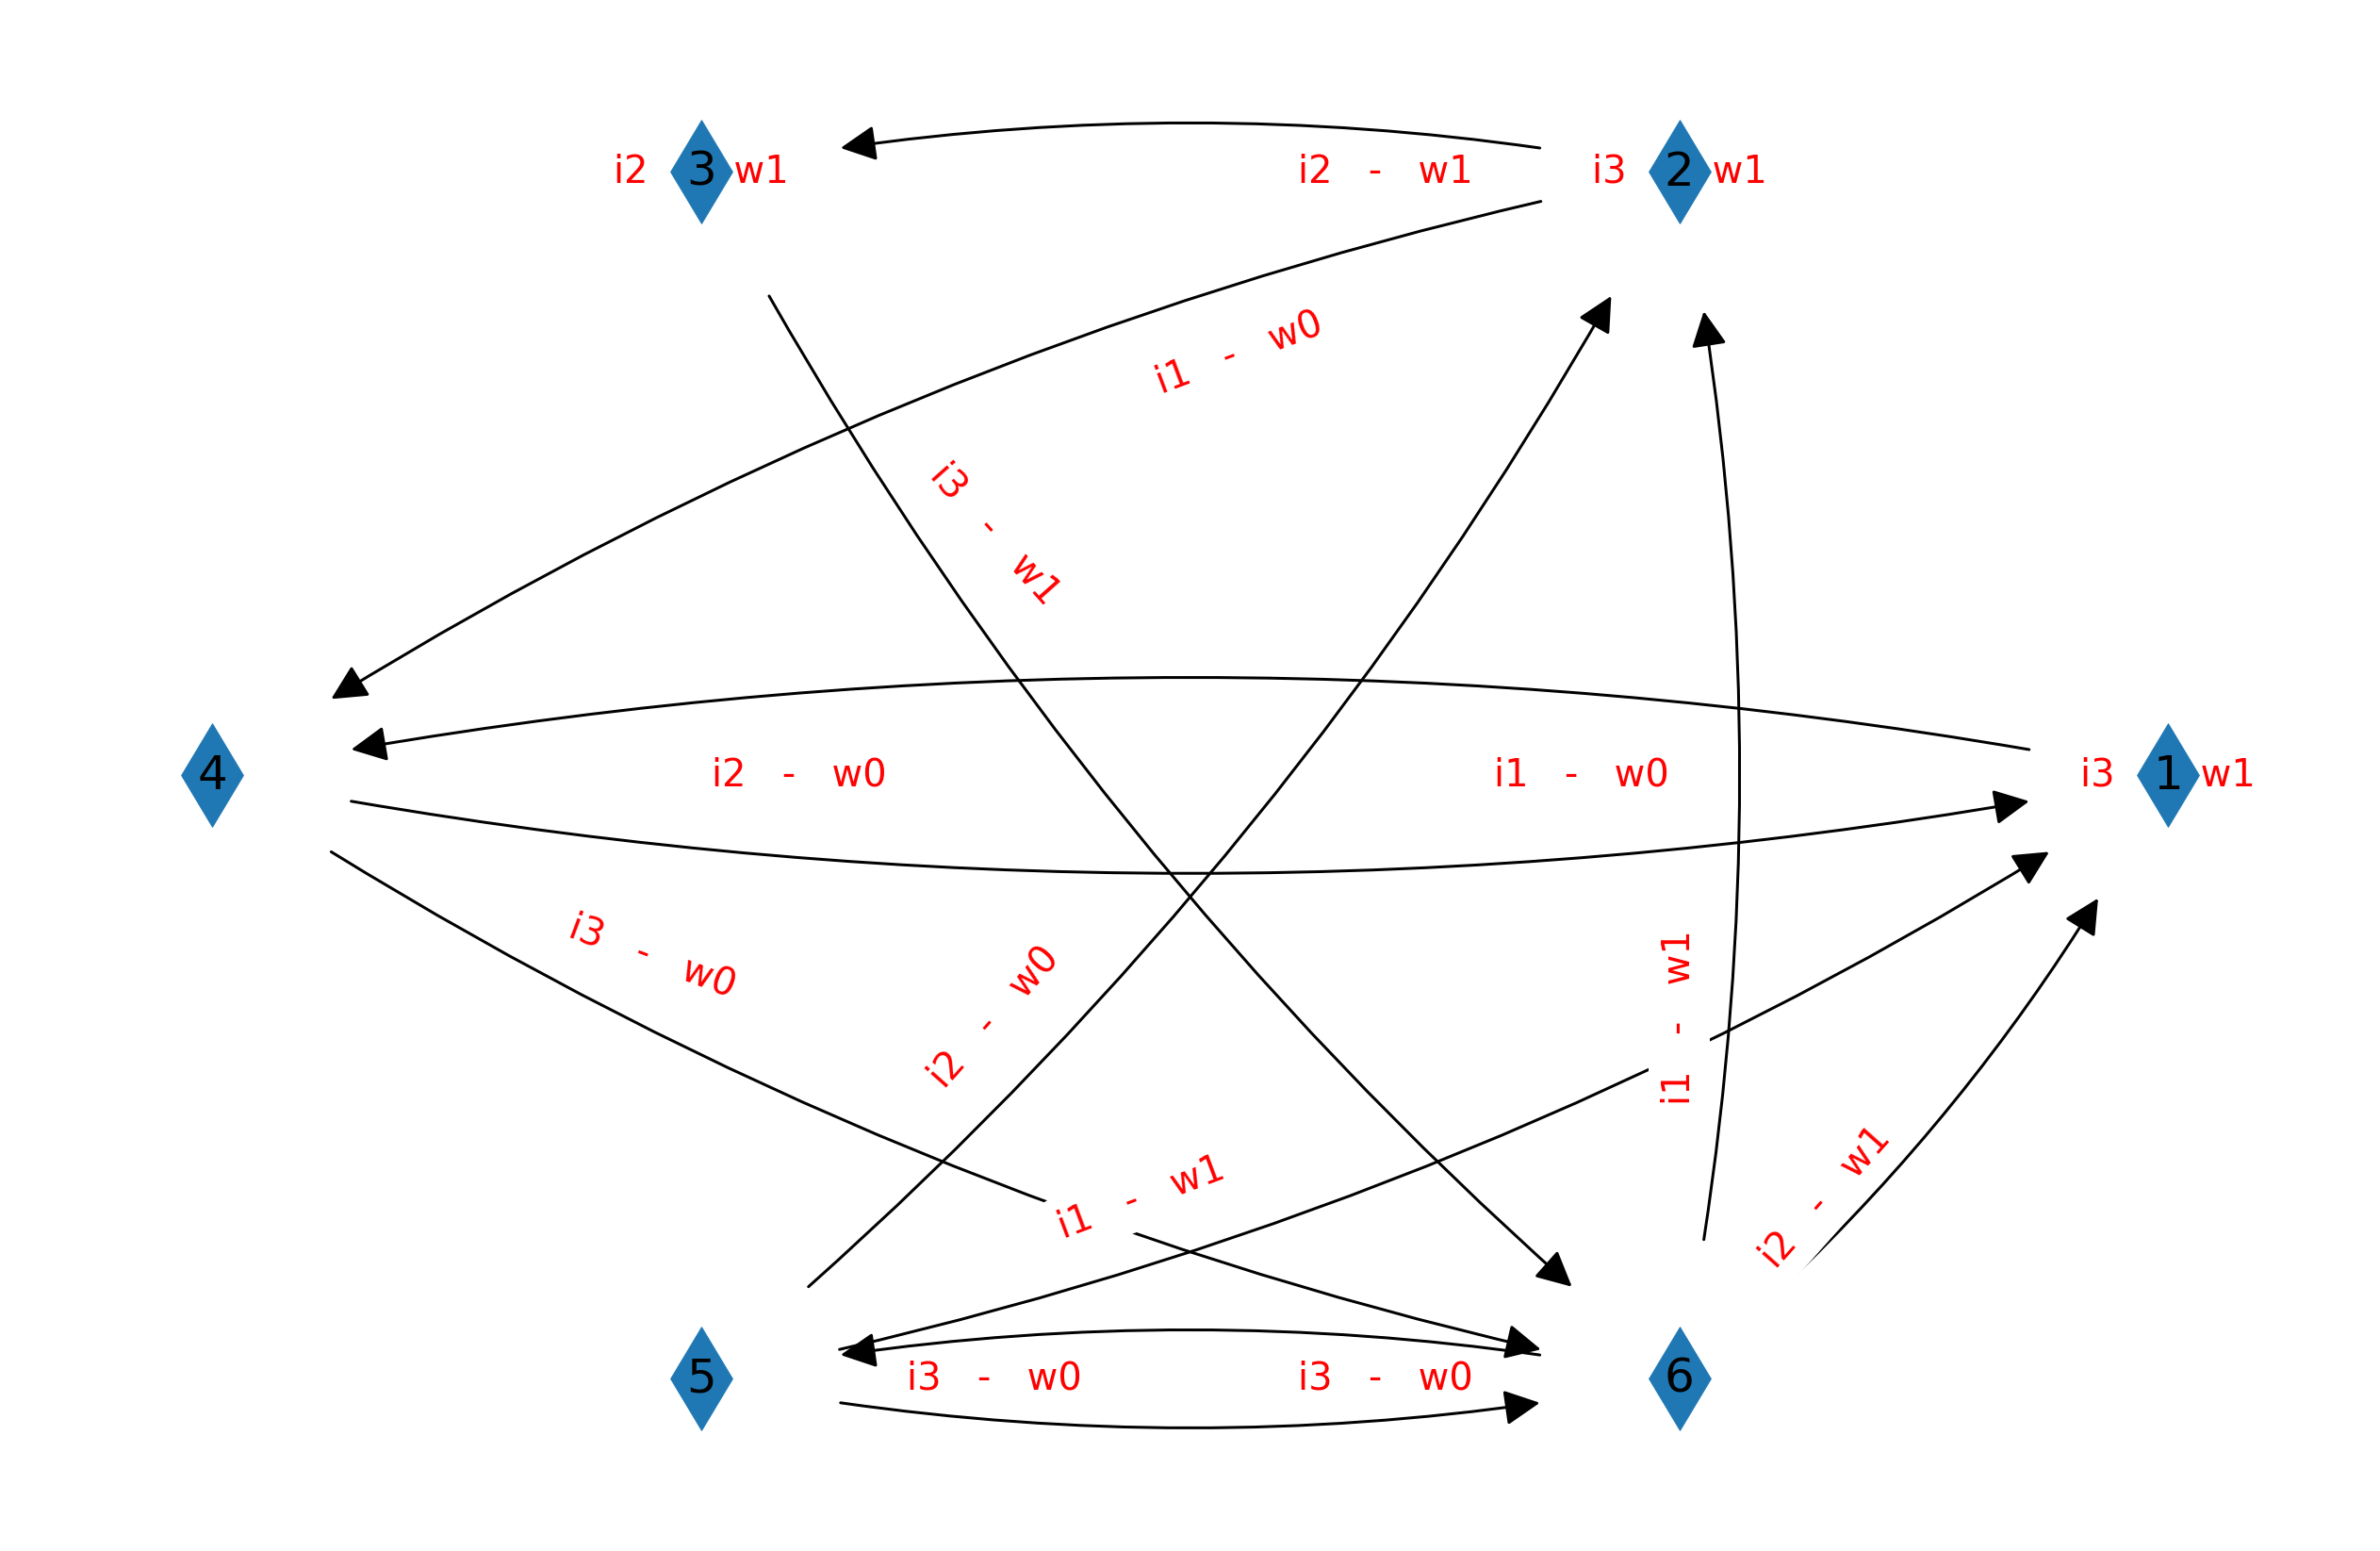

In [9]:
#Строим граф
plt.figure(figsize=(45, 30))
G = nx.DiGraph()

for i, j in minimizedTableMovements.iteritems():
    G.add_node(i)

pos = nx.circular_layout(G)
    
for i, j in minimizedTableMovements.iteritems():
    for k, l in j.items():
        G.add_edge(i, l)
        nx.draw_networkx_edge_labels(G, pos, label_pos=0.7, edge_labels = {(i, l): "i" + str(k) + "   -   w" + str(minimizedTableOutputs[i][k])}, font_color='red', font_size=40, verticalalignment="center")
        
nx.draw_networkx_nodes(G, pos, node_size=6000, node_shape="d")
## edges
nx.draw_networkx_edges(G, pos, width=3, arrowsize=80, min_source_margin=150, min_target_margin=150, connectionstyle="arc3, rad=0.1")

nx.draw_networkx_labels(G, pos, font_size=50, font_family='sans-serif')
plt.axis('off')

plt.show()